# Read Light Curves

This notebook reads the light curve data from the `1_Light_Curves` directory using `h5py` and visualizes the results.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
time, flux_white, flux_err_white, flux, flux_err, wl, flux_white_raw, flux_err_white_raw, flux_raw, flux_err_raw = np.load('data/WASP43b_MIRI.npz').values()
# np.savez('data/WASP43b_MIRI.npz', time=time, flux_white=np.array([flux_white]), flux_err_white=np.array([flux_err_white]), flux=flux.T, flux_err=flux_err.T, wl=wl, flux_white_raw=np.array([flux_white_raw]), flux_err_white_raw=np.array([flux_err_white_raw]), flux_raw=flux_raw.T, flux_err_raw=flux_err_raw.T)

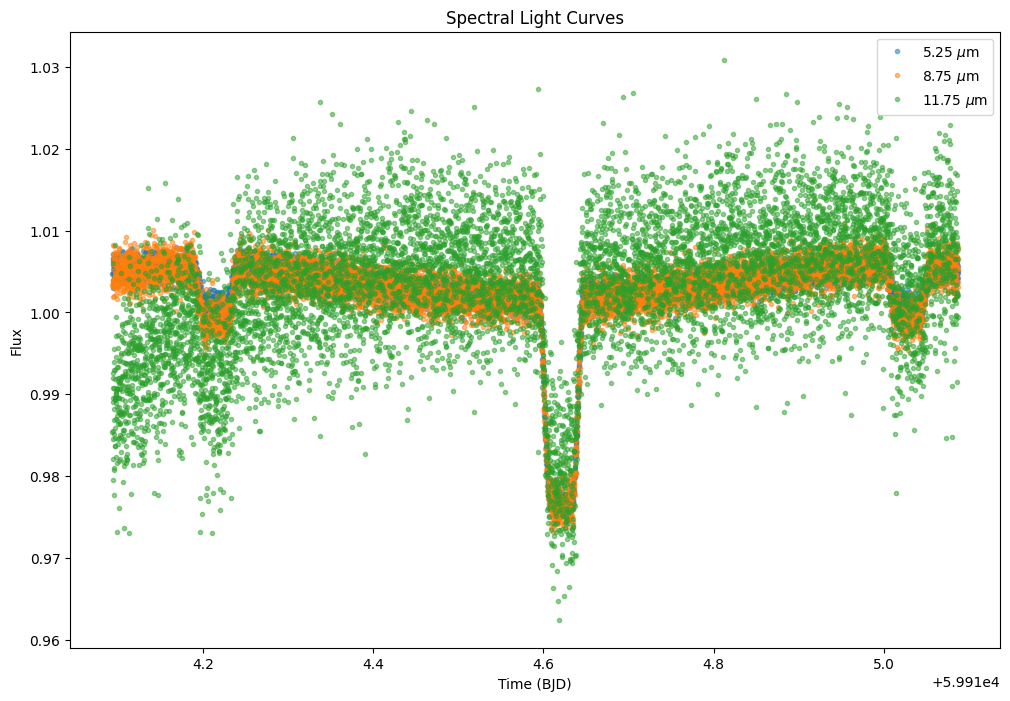

In [4]:
# Plot Spectral Light Curves for a few wavelengths
plt.figure(figsize=(12, 8))

# Plot first, middle, and last wavelength channels
indices = [0, len(wl)//2, len(wl)-1]

for i in indices:
    plt.plot(time, flux[i], '.', alpha=0.5, label=f'{wl[i]:.2f} $\mu$m')

plt.title('Spectral Light Curves')
plt.xlabel('Time (BJD)')
plt.ylabel('Flux')
plt.legend()
plt.show()

In [5]:
# Star Parameters (Source: S5_WASP-43b_fitpar_starry_white.epf / Nature Astronomy 2024)
m_star = 0.692
m_planet = 2.034 * 1.898e27 / 1.98847e30
R_sun = 6.957e8  # Radius of Sun in meters
R_J = 6.9911e7  # Radius of Jupiter in meters
fp = 6500e-6

r_star = 0.667
r_planet = 1.049 * R_J / R_sun
A = dict(
    ydeg=1,  
    udeg=2,  
    inc=90,  
    amp=1.0, 
    r=r_star, 
    m=m_star, 
    prot=1.0, 
    u=[0.03, 0.2],  # u1, u2 from epf file
)

# Planet Parameters (WASP-43b)
porb = 0.81347406 # Period from epf file
t0_ref = 55934.29223313741 # BJD from epf file (55934 + 2400000.5)
# t0_ref = 55934 + 2400000.5

B = dict(
    ydeg=2,
    udeg=2,
    inc=82.27,  # inc from epf file
    r=r_planet,
    m=m_planet,  # Mass often negligible for light curve geometry (setting to 0 or keeping small)
    porb=porb,
    prot=porb,
    t0=t0_ref,
    u=[0.0, 0.0], # Planet LD usually ignored or 0
    Omega=0,
    ecc=0.0,
    w=90, # Argument of periastron from epf file
)  

print(f"Using T0: {B['t0']}")
print(f"Using Period: {B['porb']}")

Using T0: 55934.29223313741
Using Period: 0.81347406


In [6]:
import starry
starry.config.lazy = False
starry.config.quiet = True
pri = starry.Primary(
    starry.Map(ydeg=A["ydeg"], udeg=A["udeg"], inc=90),
    r=A["r"],
    m=A["m"],
    prot=A["prot"],
)

/Users/rworzger/miniconda3/envs/spectralmap/lib/python3.9/site-packages/starry/_core/ops/limbdark/base_op.py:5: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
/Users/rworzger/miniconda3/envs/spectralmap/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
sec = starry.Secondary(
    starry.Map(ydeg=3, udeg=B["udeg"], inc=90), # this is map inclination
    r=B["r"],
    m=B["m"],
    porb=B["porb"],
    prot=B["prot"],
    t0=B["t0"], # time of transit
    inc=B["inc"],
    theta0=180,  # phase offset in degrees
)

In [8]:
from spectralmap.mapping import make_maps

maps = make_maps(mode='eclipse', pri=pri, sec=sec, map_res=30, ydegs=np.arange(2, 6, 1), lambdas=np.logspace(7, 12, 10), eclipse_depth=0.0045)

In [9]:
maps.a_lambda = 1.5
maps.b_lambda = 1e-10

In [10]:
from spectralmap.mapping import LightCurveData
data = LightCurveData(theta = time, flux=flux_white, flux_err=flux_err_white, wl=np.array([0.65]))

In [11]:
w_all, I_white, I_cov_white = maps.marginalized_maps(data)

lambda:  10%|█         | 1/10 [00:55<08:16, 55.13s/it]

lambda=10000000.0: Best-evidence wavelength counts by ydeg: ydeg=2: 0, ydeg=3: 0, ydeg=4: 1, ydeg=5: 0


lambda:  20%|██        | 2/10 [00:55<03:02, 22.76s/it]

lambda=35938136.63804626: Best-evidence wavelength counts by ydeg: ydeg=2: 0, ydeg=3: 0, ydeg=4: 1, ydeg=5: 0


lambda:  30%|███       | 3/10 [00:55<01:26, 12.42s/it]

lambda=129154966.50148827: Best-evidence wavelength counts by ydeg: ydeg=2: 0, ydeg=3: 0, ydeg=4: 1, ydeg=5: 0


lambda:  40%|████      | 4/10 [00:55<00:45,  7.57s/it]

lambda=464158883.3612773: Best-evidence wavelength counts by ydeg: ydeg=2: 1, ydeg=3: 0, ydeg=4: 0, ydeg=5: 0


lambda:  50%|█████     | 5/10 [00:55<00:24,  4.88s/it]

lambda=1668100537.2000558: Best-evidence wavelength counts by ydeg: ydeg=2: 1, ydeg=3: 0, ydeg=4: 0, ydeg=5: 0


lambda:  60%|██████    | 6/10 [00:55<00:13,  3.27s/it]

lambda=5994842503.189421: Best-evidence wavelength counts by ydeg: ydeg=2: 0, ydeg=3: 0, ydeg=4: 1, ydeg=5: 0


lambda:  70%|███████   | 7/10 [00:55<00:06,  2.23s/it]

lambda=21544346900.318867: Best-evidence wavelength counts by ydeg: ydeg=2: 0, ydeg=3: 0, ydeg=4: 1, ydeg=5: 0


lambda:  80%|████████  | 8/10 [00:55<00:03,  1.56s/it]

lambda=77426368268.11278: Best-evidence wavelength counts by ydeg: ydeg=2: 0, ydeg=3: 0, ydeg=4: 1, ydeg=5: 0


lambda:  90%|█████████ | 9/10 [00:56<00:01,  1.11s/it]

lambda=278255940220.7126: Best-evidence wavelength counts by ydeg: ydeg=2: 0, ydeg=3: 0, ydeg=4: 1, ydeg=5: 0


lambda: 100%|██████████| 10/10 [00:56<00:00,  5.62s/it]


lambda=1000000000000.0: Best-evidence wavelength counts by ydeg: ydeg=2: 1, ydeg=3: 0, ydeg=4: 0, ydeg=5: 0
Best-evidence wavelength counts by ydeg: ydeg=2: 0, ydeg=3: 0, ydeg=4: 1, ydeg=5: 0


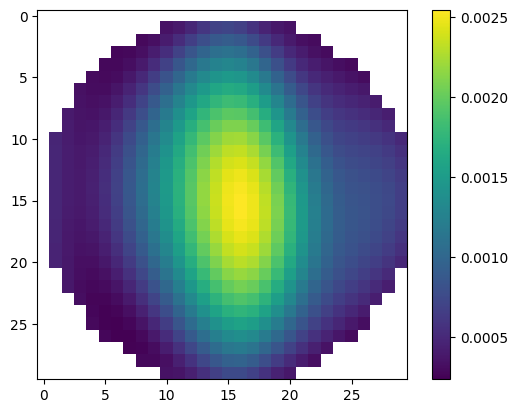

In [12]:
from spectralmap.mapping import expand_moll_values

plt.imshow(expand_moll_values(I_white, maps.moll_mask_flat).reshape(30, 30))
plt.colorbar()

Using MIRI wavelength grid from wl (14 bins)
Depth range (mean map): 7.499e-04 to 7.997e-03
Substellar Tb estimate (lon~0, lat~0): 1923.3 K


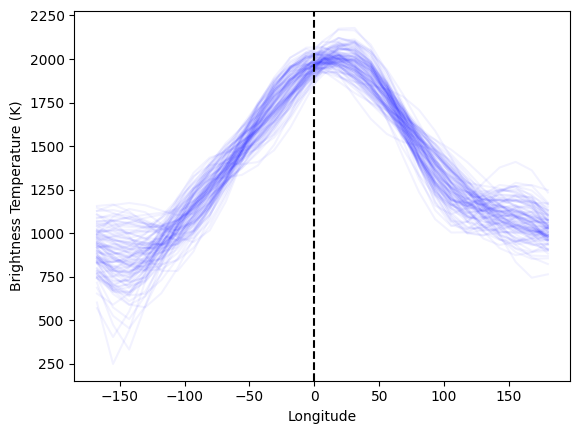

Text(0, 0.5, 'Brightness Temperature (K)')

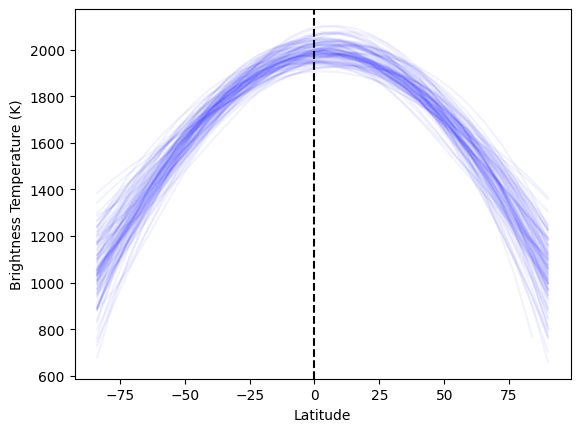

In [13]:
import importlib
import spectralmap.utilities as sm_utils
sm_utils = importlib.reload(sm_utils)

expand_moll_values = sm_utils.expand_moll_values
depth_to_tb_broadband = sm_utils.depth_to_tb_broadband
compute_bin_widths_from_centers = sm_utils.compute_bin_widths_from_centers

I_plot = I_white[0]
I_cov_plot = I_cov_white[0]
N = 100
samples = np.random.multivariate_normal(I_plot, I_cov_plot, N)

n_lat, n_lon = maps.map_res, maps.map_res
lons, lats = np.linspace(-180, 180, n_lon), np.linspace(-90, 90, n_lat)

# Use MIRI wavelength grid directly from the dataset
wl_band = np.asarray(wl, dtype=float)
dlam_band = compute_bin_widths_from_centers(wl_band)

RpRs = 0.1588

# Quick diagnostics to catch inflated temperatures
I_mean_map = expand_moll_values(I_plot, maps.moll_mask_flat).reshape(n_lat, n_lon)
depth_mean_map = np.pi * I_mean_map
Tb_mean_map = depth_to_tb_broadband(depth_mean_map, wl_band, dlam_band, RpRs, t_star=4500.0)
i_lat0 = int(np.argmin(np.abs(lats)))
i_lon0 = int(np.argmin(np.abs(lons)))
print(f"Using MIRI wavelength grid from wl ({wl_band.size} bins)")
print(f"Depth range (mean map): {np.nanmin(depth_mean_map):.3e} to {np.nanmax(depth_mean_map):.3e}")
print(f"Substellar Tb estimate (lon~0, lat~0): {Tb_mean_map[i_lat0, i_lon0]:.1f} K")

for i in range(N):
    I_slice = expand_moll_values(samples[i], maps.moll_mask_flat).reshape(n_lat, n_lon)[n_lat // 2]
    depth_slice = np.pi * I_slice
    Tb_slice = depth_to_tb_broadband(depth_slice, wl_band, dlam_band, RpRs, t_star=4500.0)
    finite = np.isfinite(Tb_slice)
    plt.plot(lons[finite], Tb_slice[finite], c='b', alpha=0.05)
plt.axvline(0, color='k', linestyle='--', linewidth=1.5)
plt.xlabel('Longitude')
plt.ylabel('Brightness Temperature (K)')

plt.show()
for i in range(N):
    I_slice = expand_moll_values(samples[i], maps.moll_mask_flat).reshape(n_lat, n_lon)[:, n_lon // 2]
    depth_slice = np.pi * I_slice
    Tb_slice = depth_to_tb_broadband(depth_slice, wl_band, dlam_band, RpRs, t_star=4500.0)
    finite = np.isfinite(Tb_slice)
    plt.plot(lats[finite], Tb_slice[finite], c='b', alpha=0.05)
plt.axvline(0, color='k', linestyle='--', linewidth=1.5)
plt.xlabel('Latitude')
plt.ylabel('Brightness Temperature (K)')

In [14]:
from spectralmap.mapping import Map, Maps
maps = make_maps(mode='eclipse', pri=pri, sec=sec, map_res=30, ydegs=np.arange(2, 5, 1), lambdas=np.logspace(4, 9, 20), eclipse_depth=0.0045, a_lambda=1e-10, b_lambda=1e-10, verbose=False)
data = LightCurveData(theta = time, flux=flux, flux_err=flux_err, wl=wl)
w_all, I_all_wl, I_cov_all_wl = maps.marginalized_maps(data)

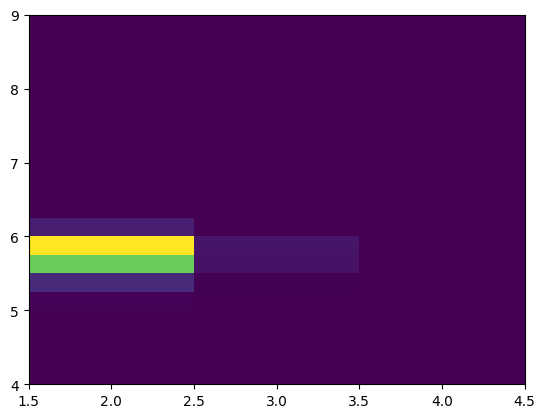

In [15]:
plt.imshow(w_all[..., 4], extent=(maps.ydegs.min()-0.5, maps.ydegs.max()+0.5, np.log10(maps.lambdas[0]), np.log10(maps.lambdas[-1])), aspect='auto', origin='lower')

Using bin center = 5.250 micron, bin width = 0.5000 micron
Depth range (mean map): 5.713e-04 to 1.004e-02
Substellar Tb estimate (lon~0, lat~0): 1803.9 K


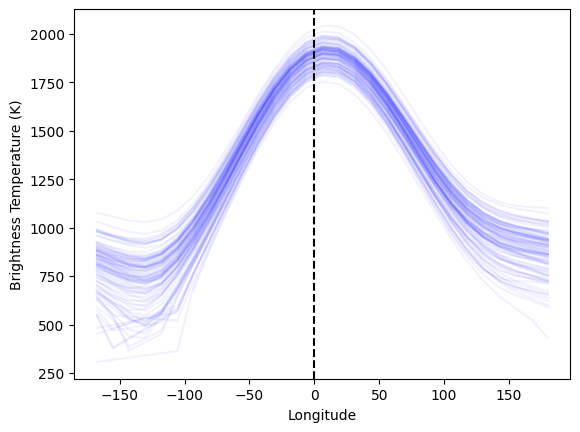

Text(0, 0.5, 'Brightness Temperature (K)')

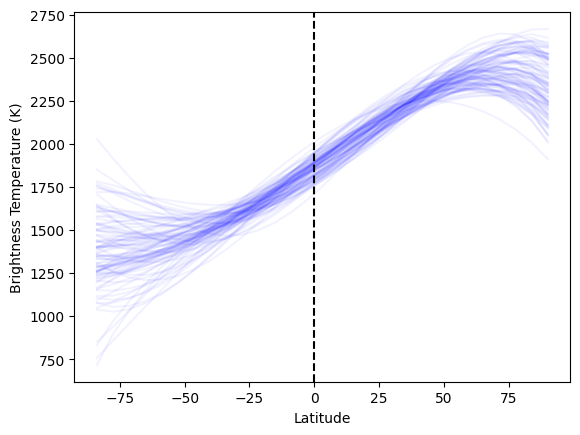

In [16]:
import importlib
import spectralmap.utilities as sm_utils
sm_utils = importlib.reload(sm_utils)

expand_moll_values = sm_utils.expand_moll_values
compute_bin_widths_from_centers = sm_utils.compute_bin_widths_from_centers
depth_to_tb_broadband = sm_utils.depth_to_tb_broadband

i_wl = 0
I_plot = I_all_wl[i_wl]
I_cov_plot = I_cov_all_wl[i_wl]
N = 100
samples = np.random.multivariate_normal(I_plot, I_cov_plot, N)

n_lat, n_lon = maps.map_res, maps.map_res
lons, lats = np.linspace(-180, 180, n_lon), np.linspace(-90, 90, n_lat)


wl_band_i_wl = wl_band[i_wl]
dlam_band_i_wl = dlam_band[i_wl]
RpRs = 0.1588

# Quick diagnostics to catch inflated temperatures
I_mean_map = expand_moll_values(I_plot, maps.moll_mask_flat).reshape(n_lat, n_lon)
depth_mean_map = np.pi * I_mean_map
Tb_mean_map = depth_to_tb_broadband(depth_mean_map, wl_band_i_wl, dlam_band_i_wl, RpRs, t_star=4500.0)
i_lat0 = int(np.argmin(np.abs(lats)))
i_lon0 = int(np.argmin(np.abs(lons)))
print(f"Using bin center = {wl_band_i_wl:.3f} micron, bin width = {dlam_band_i_wl:.4f} micron")
print(f"Depth range (mean map): {np.nanmin(depth_mean_map):.3e} to {np.nanmax(depth_mean_map):.3e}")
print(f"Substellar Tb estimate (lon~0, lat~0): {Tb_mean_map[i_lat0, i_lon0]:.1f} K")

for i in range(N):
    I_slice = expand_moll_values(samples[i], maps.moll_mask_flat).reshape(n_lat, n_lon)[n_lat // 2]
    depth_slice = np.pi * I_slice
    Tb_slice = depth_to_tb_broadband(depth_slice, wl_band_i_wl, dlam_band_i_wl, RpRs, t_star=4500.0)
    finite = np.isfinite(Tb_slice)
    plt.plot(lons[finite], Tb_slice[finite], c='b', alpha=0.05)
plt.axvline(0, color='k', linestyle='--', linewidth=1.5)
plt.xlabel('Longitude')
plt.ylabel('Brightness Temperature (K)')

plt.show()
for i in range(N):
    I_slice = expand_moll_values(samples[i], maps.moll_mask_flat).reshape(n_lat, n_lon)[:, n_lon // 2]
    depth_slice = np.pi * I_slice
    Tb_slice = depth_to_tb_broadband(depth_slice, wl_band_i_wl, dlam_band_i_wl, RpRs, t_star=4500.0)
    finite = np.isfinite(Tb_slice)
    plt.plot(lats[finite], Tb_slice[finite], c='b', alpha=0.05)
plt.axvline(0, color='k', linestyle='--', linewidth=1.5)
plt.xlabel('Latitude')
plt.ylabel('Brightness Temperature (K)')

In [21]:
from tqdm.auto import tqdm

I_all_wl_sampled = []
target_n = 1000
batch_size = 1000
nwl = len(wl)
for i in tqdm(range(nwl), total=nwl, desc="Sampling wavelengths"):
    I_sampled = []
    while len(I_sampled) < target_n:
        batch = np.random.multivariate_normal(
            I_all_wl[i], I_cov_all_wl[i], size=batch_size
        )
        positive_batch = batch[(batch > 0).all(axis=1)]

        n_need = target_n - len(I_sampled)
        if positive_batch.shape[0] > 0:
            I_sampled.extend(positive_batch[:n_need])

    I_all_wl_sampled.append(np.asarray(I_sampled))

Sampling wavelengths: 100%|██████████| 14/14 [00:31<00:00,  2.26s/it]


In [22]:
amplitudes = np.ones(I_all_wl.shape[0])  # Placeholder for actual amplitude scaling per wavelength

# Convert sampled intensities to eclipse-depth flux samples
I_all_wl_sampled = np.asarray(I_all_wl_sampled, dtype=float)  # (nwl, nsamp, npix)
F_all_wl_sampled = I_all_wl_sampled * amplitudes[:, None, None] * np.pi

# Mean flux map per wavelength
F_all_wl = np.mean(F_all_wl_sampled, axis=1)

# Full covariance per wavelength estimated from samples (captures correlations)
nwl = F_all_wl_sampled.shape[0]
npix = F_all_wl_sampled.shape[-1]
F_cov_all_wl = np.zeros((nwl, npix, npix), dtype=float)
for i in range(nwl):
    F_cov_all_wl[i] = np.cov(F_all_wl_sampled[i], rowvar=False, ddof=1)

# Variance is the diagonal of the sample covariance
F_var_all_wl = np.diagonal(F_cov_all_wl, axis1=1, axis2=2)

-1 338
0 74
1 100
2 100
3 87
F_regionals shape: (5, 14)
F_regional_errs shape: (5, 14)
labels unique (full map): [-1  0  1  2  3]


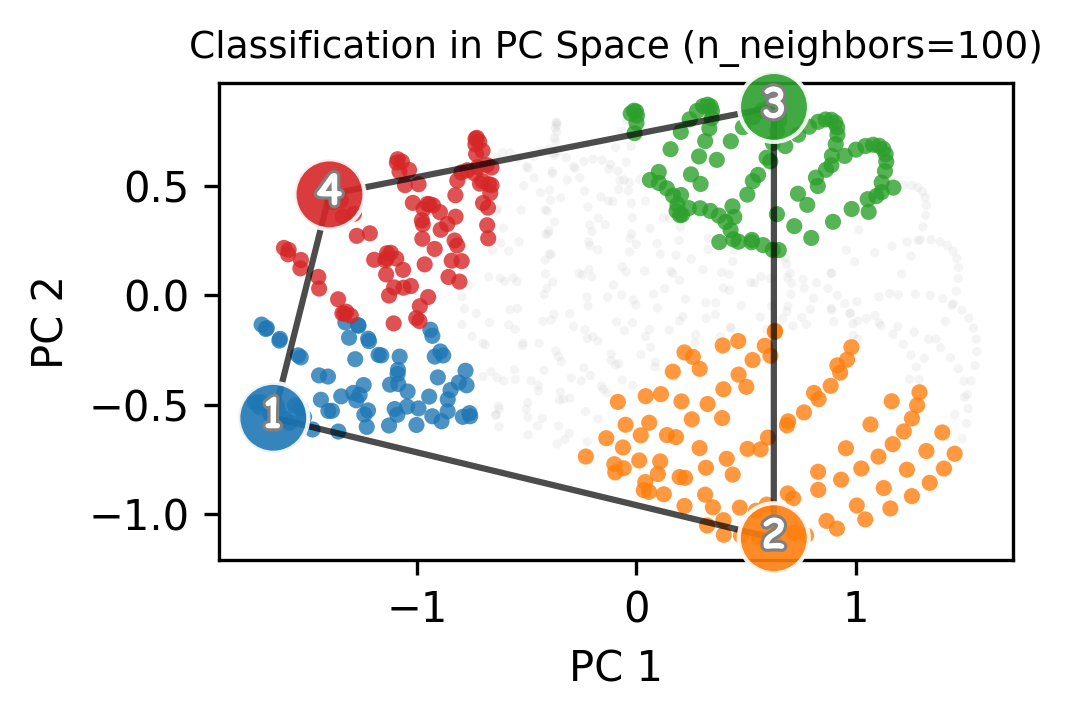

In [23]:
from spectralmap.cluster import find_clusters

# amplitudes = np.ones(I_all_wl.shape[0])  # Placeholder for actual amplitude scaling per wavelength
# F_all_wl = I_all_wl * amplitudes[:, None] *np.pi
# F_cov_all_wl = I_cov_all_wl * (np.pi * amplitudes[:, None, None])**2
# F_var_all_wl = np.diagonal(F_cov_all_wl, axis1=1, axis2=2)
# F_all_wl[F_all_wl<0] = 1e-6

F_regionals, F_regional_errs, labels = find_clusters(
    F_all_wl,
    F_cov_all_wl,
    n_corners=4,
    n_neighbors=100,
)


print('F_regionals shape:', F_regionals.shape)
print('F_regional_errs shape:', F_regional_errs.shape)
print('labels unique (full map):', np.unique(labels))

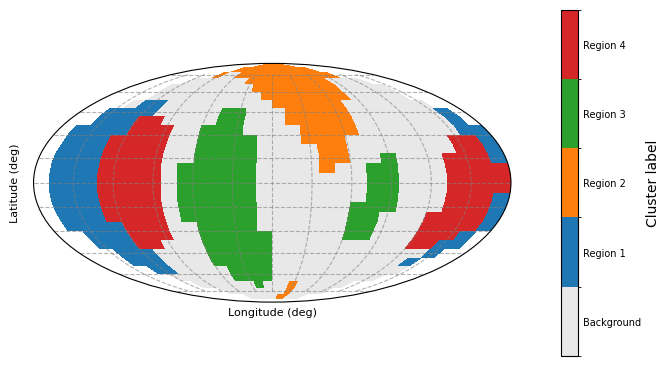

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from spectralmap.utilities import plot_mollweide_labels
from matplotlib import colors as mcolors

colors_list = ['#E8E8E8']  # Background
region_colors = plt.get_cmap('tab10').colors
N = len(F_regionals)
for i in range(N - 1):
    colors_list.append(region_colors[i % len(region_colors)])

cluster_names = ["Background"] + [f"Region {i+1}" for i in range(N - 1)]
cmap = mcolors.ListedColormap(colors_list)

fig, ax, pcm, cb = plot_mollweide_labels(
    labels_masked=labels,      # should be ints 0..N-1 on masked pixels
    moll_mask=maps.moll_mask,
    map_res=maps.map_res,
    cmap=cmap,
    names=cluster_names,
    extrapolate=False
)

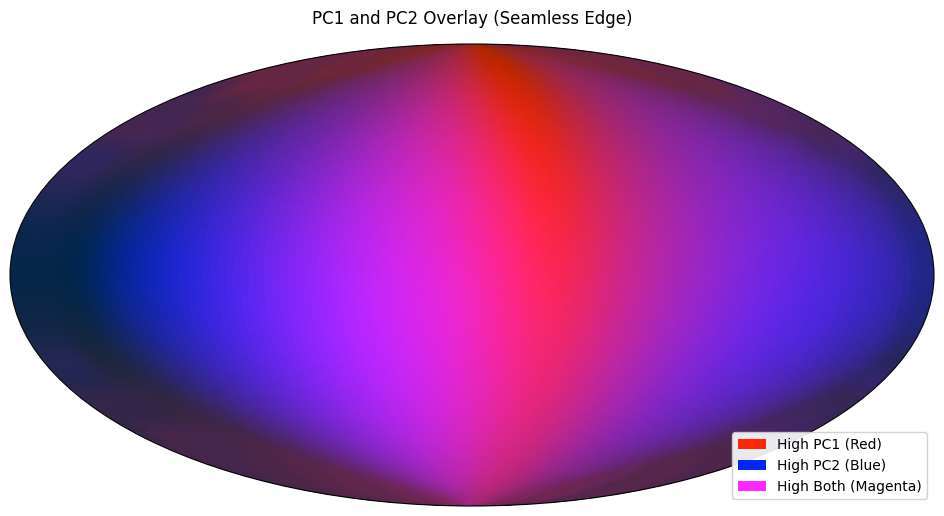

In [25]:
from sklearn.decomposition import PCA
from spectralmap.utilities import expand_moll_values, plot_mollweide_rgb_perfect_edges
pca = PCA(n_components=2)
PCs = pca.fit_transform(np.log(F_all_wl).T)  # shape: (n_wavelengths, 2)
pc1_scores = PCs[:, 0]
pc2_scores = PCs[:, 1]

mask_2d = (maps.lon > maps.observed_lon_range[0]) & (maps.lon < maps.observed_lon_range[1]) if maps.observed_lon_range is not None else maps.moll_mask

fig, ax = plot_mollweide_rgb_perfect_edges(pc1_scores, pc2_scores, mask_2d, upsample=4)
plt.show()

F_regionals shape: (5, 14)
F_regionals mean: 0.0034951292171913
Tb_all shape: (5, 14)
Tb_all mean: 1165.6033063479506


Text(0, 0.5, 'Brightness Temperature (K)')

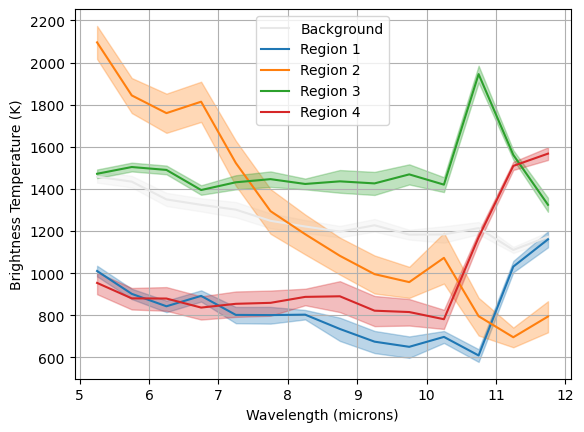

In [ ]:
stellar_radiance_model = None

# --- Example Usage ---
RpRs = 0.1588 # From ExFig3.py
print("F_regionals shape:", F_regionals.shape)
print("F_regionals mean:", np.mean(F_regionals))

# Fix applied: Convert Starry Intensity to Eclipse Depth (Flux)
# Starry Intensity I integrates to Flux F = pi * I on the unit disk
# The conversion function expects Flux (Eclipse Depth), so we multiply by pi.
Tb_all = depth_to_tb_broadband(F_regionals, wl_band, dlam_band, RpRs, stellar_model=stellar_radiance_model, t_star=4500)
Tb_upper_all = depth_to_tb_broadband((F_regionals + F_regional_errs), wl_band, dlam_band, RpRs, stellar_model=stellar_radiance_model, t_star=4500)
Tb_lower_all = depth_to_tb_broadband((F_regionals - F_regional_errs), wl_band, dlam_band, RpRs, stellar_model=stellar_radiance_model, t_star=4500)
Tb_lower_all[np.isnan(Tb_lower_all)] = 1e-6
print("Tb_all shape:", Tb_all.shape)
print("Tb_all mean:", np.mean(Tb_all))


for i in range(len(Tb_all)):
    if i==0:
        label='Background'
    else:
        label=f'Region {i}'
    plt.plot(wl, Tb_all[i], color=colors_list[i % len(colors_list)], label=label)
    plt.fill_between(wl, Tb_lower_all[i], Tb_upper_all[i], color=colors_list[i % len(colors_list)], alpha=0.3)
plt.grid()
plt.legend(loc='best')
plt.xlabel('Wavelength (microns)')
plt.ylabel('Brightness Temperature (K)')

In [ ]:
# Prior on primary
pri_mu = np.zeros(pri.map.Ny)
pri_mu[0] = 1.0
pri_L = np.zeros(pri.map.Ny)
pri_L[0] = 1e-10
pri_L[1:] = 1e-10
pri.map.set_prior(mu=pri_mu, L=pri_L)

# Prior on secondary
sec_mu = np.zeros(sec.map.Ny)
sec_mu[0] = 0.001
sec_L = np.zeros(sec.map.Ny)
sec_L[0] = 1e-1
sec_L[1:] = 1e-1
sec.map.set_prior(mu=sec_mu, L=sec_L)

In [ ]:
sys = starry.System(pri, sec)

In [ ]:
sys.set_data(flux=flux_white, C=flux_err_white[:] ** 2)
mu, cho_cov = sys.solve(t=time)
flux_fit = sys.flux(time)

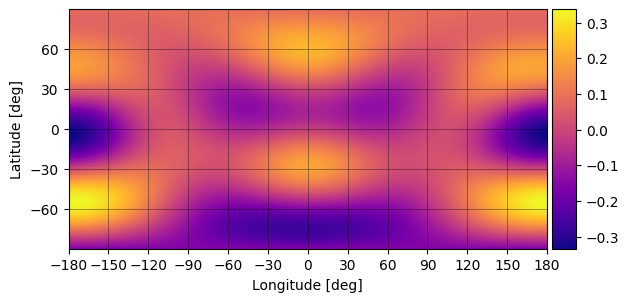

In [ ]:
sec.map.show(projection='rect', colorbar=True)

In [ ]:
# sys.show(t=time, window_pad=2,figsize=(5, 5),interval=10)

Text(0.5, 1.0, 'White Light Curve Fit')

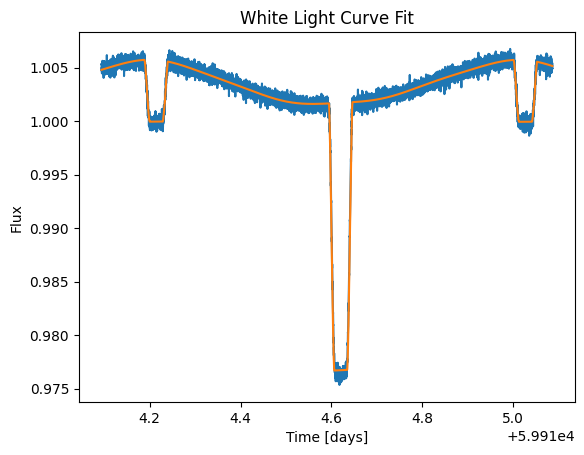

In [ ]:
import matplotlib.pyplot as plt
plt.plot(time, flux_white)
plt.plot(time, flux_fit)
plt.ylabel('Flux')
plt.xlabel('Time [days]')
plt.title(f'White Light Curve Fit')